# Image Classification 2D

>BloodMNIST Dataset Demo: This tutorial provides a comprehensive, step-by-step guide to using the bioMONAI platform for 2D microscopy image classification tasks. 

In [ ]:
#| default_exp tutorial_classification

### Setup imports

In [ ]:
from bioMONAI.data import *
from bioMONAI.transforms import *
from bioMONAI.core import *
from bioMONAI.core import Path
from bioMONAI.data import get_image_files
from bioMONAI.losses import *
from bioMONAI.metrics import *
from bioMONAI.datasets import download_medmnist

from fastai.vision.all import CategoryBlock, GrandparentSplitter, parent_label, resnet34, CrossEntropyLossFlat, accuracy

In [ ]:
device = get_device()
print(device)

cuda


### Dataset Information and Download

We'll employ the publicly available BloodMNIST dataset. The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes.



> In this step, we will download the BloodMNIST dataset using the `download_medmnist` function from bioMONAI. This function will download the dataset and provide information about it. The dataset will be stored in the specified path. You can customize the path or dataset name as needed. Additionally, you can explore other datasets available in the MedMNIST collection by changing the dataset name in the `download_medmnist` function.

In [ ]:
image_path = Path('../_data/medmnist_data/')
info = download_medmnist('bloodmnist', image_path, download_only=True)

100%|██████████| 35461855/35461855 [00:11<00:00, 2982324.85it/s]


Using downloaded and verified file: ../_data/medmnist_data/bloodmnist/bloodmnist.npz
Using downloaded and verified file: ../_data/medmnist_data/bloodmnist/bloodmnist.npz
Saving training images to ../_data/medmnist_data/bloodmnist...


100%|██████████| 11959/11959 [00:34<00:00, 345.45it/s]


Saving validation images to ../_data/medmnist_data/bloodmnist...


100%|██████████| 1712/1712 [00:04<00:00, 370.37it/s]


Saving test images to ../_data/medmnist_data/bloodmnist...


100%|██████████| 3421/3421 [00:09<00:00, 342.58it/s]

Removed bloodmnist.npz
Datasets downloaded to ../_data/medmnist_data/bloodmnist
Dataset info for 'bloodmnist': {'python_class': 'BloodMNIST', 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.', 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1', 'MD5': '7053d0359d879ad8a5505303e11de1dc', 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1', 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b', 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1', 'MD5_128

### Create DataLoader

In this step, we will customize the DataLoader for the BloodMNIST dataset. The DataLoader is responsible for loading the data during training and validation. We will define the data loading strategy using the `BioDataLoaders.from_source()` method, which is is the most general method to deal with various kinds of data and tasks. We will configure the dataloader with the arguments specified in `data_ops`. 

>You can customize the following parameters to suit your needs:
>- `batch_size`: The number of samples per batch. Adjust this based on your GPU memory capacity.
>- `item_tfms`: List of item-level transformations to apply to the images. You can add or modify transformations to augment your dataset.
>- `splitter`: The method to split the dataset into training and validation sets. You can customize the split strategy if needed.
>
> Feel free to experiment with different configurations to improve model performance or adapt to different datasets.

In [ ]:
batch_size = 32

path = image_path/'bloodmnist'
train_path = path/'train'
val_path = path/'val'

data_ops = {
    'blocks':       (BioImageBlock(cls=BioImageMulti), CategoryBlock(info['label'])),              # define a `TransformBlock` tailored for bioimaging data
    'get_items':    get_image_files,                                                               # get image files in path
    'get_y':        parent_label,                                                                  # Label item with the parent folder name
    'splitter':     GrandparentSplitter(train_name='train', valid_name='val'),                     # split data with the grandparent folder name
    'item_tfms':    [ScaleIntensity(min=0.0, max=1.0), RandRot90(prob=0.75), RandFlip(prob=0.75)], # list of item transforms
    'bs':           batch_size,                                                                    # batch size
}

data = BioDataLoaders.from_source(
    path,                           # root directory for data
    show_summary=False,             # print summary of the data
    **data_ops,                     # rest of method arguments
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 11959 
validation images: 1712


### Visualize a Batch of Images

In this step, we will visualize a batch of images from the BloodMNIST dataset using the `show_batch` method. This will help us understand the data distribution and verify the transformations applied to the images. The `max_n` parameter specifies the number of images to display.

> - You can adjust the `max_n` parameter to display more or fewer images.
> - Experiment with different transformations in the `item_tfms` list to see their effects on the images.
> - Use the `show_batch` method at different stages of your data pipeline to ensure the data is being processed correctly.

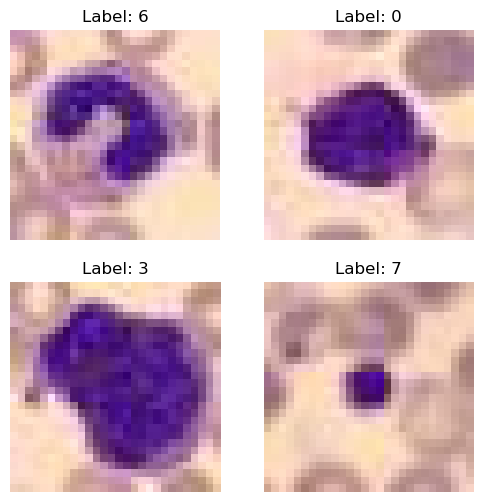

In [ ]:
data.show_batch(max_n=4)

### Train the Model

In this step, we will train the model using the `visionTrainer` class. The `fine_tune` method will be used to fine-tune the model for a specified number of epochs. The `freeze_epochs` parameter allows you to freeze the initial layers of the model for a certain number of epochs before unfreezing and training the entire model.

> - You can adjust the `epochs` parameter to train the model for more or fewer epochs based on your dataset and computational resources.
> - Experiment with different values for `freeze_epochs` to see how it affects model performance.
> - Monitor the training process and adjust the learning rate or other hyperparameters if needed.
> - Consider using techniques like early stopping or learning rate scheduling to improve training efficiency and performance.

##### VisionTrainer Class

The `visionTrainer` class is a high-level API designed to simplify the training process for vision models. It provides a convenient interface for training, fine-tuning, and evaluating deep learning models. Here are some key features and functionalities of the `visionTrainer` class:

- **Initialization**: The class is initialized with the data, model architecture, loss function, and metrics. It also provides options to display a summary of the model and data.
- **Fine-tuning**: The `fine_tune` method allows you to fine-tune the model for a specified number of epochs. You can freeze the initial layers of the model for a certain number of epochs before unfreezing and training the entire model.
- **Training**: The class handles the training loop, including forward and backward passes, loss computation, and optimization.
- **Evaluation**: The class provides methods to evaluate the model on validation and test datasets, compute metrics, and visualize results.
- **Customization**: You can customize various aspects of the training process, such as learning rate, batch size, and data augmentations, to suit your specific needs.

> The `visionTrainer` class is designed to streamline the training process, making it easier to experiment with different models and hyperparameters. It is particularly useful for tasks like image classification, where you can leverage pre-trained models and fine-tune them on your dataset.

In [ ]:
model = resnet34

loss = CrossEntropyLossFlat()
metrics = accuracy

trainer = visionTrainer(data, model, loss_fn=loss, metrics=metrics, show_summary=False)

epoch,train_loss,valid_loss,accuracy,time


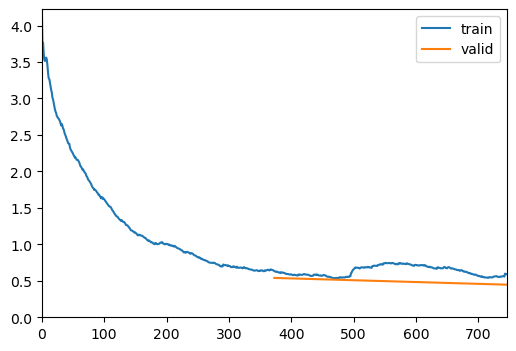

epoch,train_loss,valid_loss,accuracy,time
0,0.303882,0.200634,0.936332,00:18
1,0.327721,0.320398,0.897780,00:20
2,0.331424,2.432861,0.506425,00:18
3,0.321495,0.411227,0.863902,00:20
4,0.266707,0.349412,0.886098,00:19
5,0.262396,0.180110,0.942757,00:19
6,0.174764,0.156755,0.945093,00:20
7,0.225743,0.415864,0.945093,00:19
8,0.201109,2.398070,0.937500,00:19
9,0.172872,1.222175,0.943925,00:19


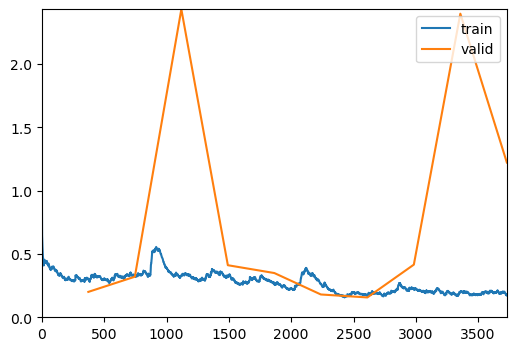

In [ ]:
trainer.fine_tune(10, freeze_epochs=2)

### Evaluate the Model on Validation Data

In this step, we will evaluate the trained model on the validation dataset using the `evaluate_classification_model` function. This function computes the specified metrics and provides insights into the model's performance. Additionally, it can display the most confused classes to help identify areas for improvement.

> - You can customize the `metrics` parameter to include other evaluation metrics relevant to your task.
> - The `most_confused_n` parameter specifies the number of most confused classes to display. Adjust this value to see more or fewer confused classes.
> - Set the `show_graph` parameter to `True` to visualize the confusion matrix and other evaluation graphs.
> - Use this evaluation step to monitor the model's performance and make necessary adjustments to the training process or data pipeline.

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       122
           1       0.94      0.99      0.96       312
           2       0.97      0.94      0.96       155
           3       0.87      0.91      0.89       290
           4       0.93      0.93      0.93       122
           5       0.91      0.80      0.85       143
           6       0.98      0.98      0.98       333
           7       1.00      1.00      1.00       235

    accuracy                           0.94      1712
   macro avg       0.94      0.93      0.94      1712
weighted avg       0.94      0.94      0.94      1712


Most Confused Classes:


[('5', '1', 13), ('5', '3', 12), ('4', '3', 8), ('2', '3', 7), ('3', '5', 7), ('3', '0', 6), ('3', '6', 6)]


,Value
CrossEntropyLossFlat,
Mean,1.343377
Median,1.275471
Standard Deviation,0.189204
Min,1.274009
Max,2.274009
Q1,1.274119
Q3,1.293267


,Value
accuracy,
Mean,0.944509
Median,1.000000
Standard Deviation,0.228935
Min,0.000000
Max,1.000000
Q1,1.000000
Q3,1.000000


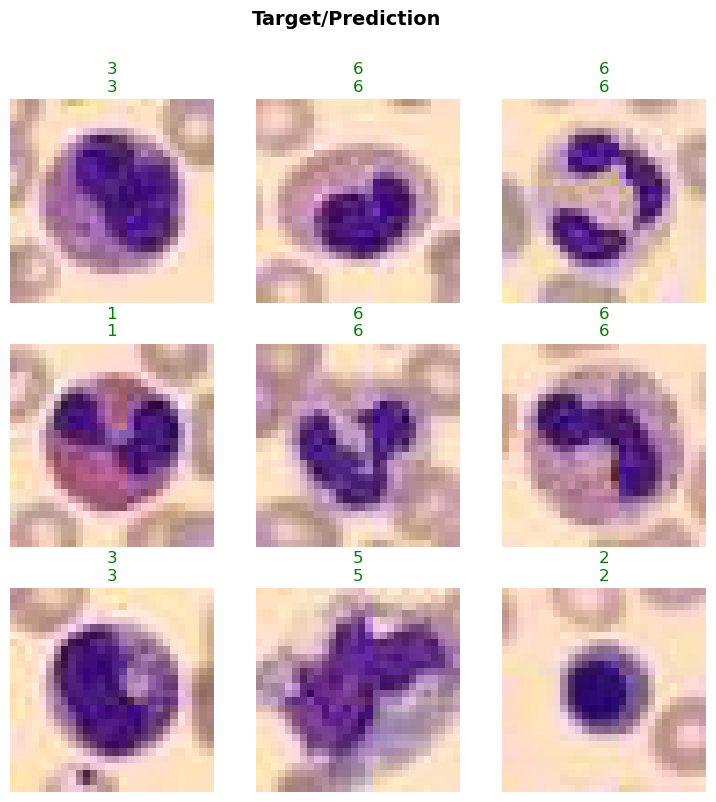

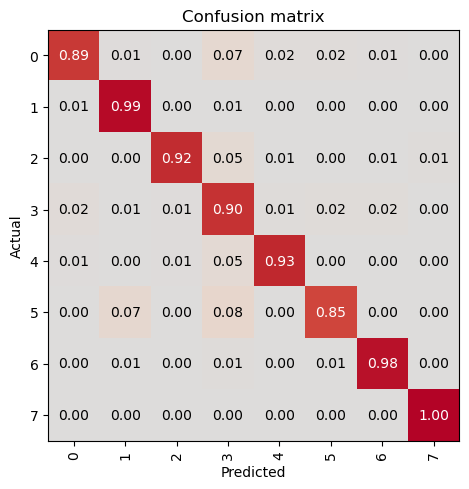

In [ ]:
evaluate_classification_model(trainer,  metrics=metrics, most_confused_n=5, show_graph=False);

### Save the Model

In this step, we will save the trained model using the `save` method of the `visionTrainer` class. Saving the model allows us to reuse it later without retraining. This is particularly useful when you want to deploy the model or continue training at a later time.

> - You can specify the file path and name for the saved model. Ensure the directory exists or create it if necessary.
> - Consider saving the model at different checkpoints during training to have backups and the ability to revert to a previous state if needed.
> - You can also save additional information such as the training history, optimizer state, and hyperparameters to facilitate future use or further training.

In [ ]:
trainer.save('tmp-model')

Path('models/tmp-model.pth')

### Evaluate the Model on Test Data

In this step, we will evaluate the trained model on the test dataset to assess its performance on unseen data. This is a crucial step to ensure that the model generalizes well and performs accurately on new, unseen samples. We will use the `evaluate_classification_model` function to compute the specified metrics and gain insights into the model's performance.

> - Ensure that the test dataset is completely separate from the training and validation datasets to get an unbiased evaluation.
> - You can customize the `metrics` parameter to include other evaluation metrics relevant to your task.
> - The `show_graph` parameter can be set to `True` to visualize the confusion matrix and other evaluation graphs.
> - Use this evaluation step to identify any potential issues with the model and make necessary adjustments to the training process or data pipeline.
> - Consider experimenting with different model architectures, hyperparameters, and data augmentations to further improve performance.

In [ ]:
test_path = path/'test'

test_data = data.test_dl(get_image_files(test_path).shuffle(), with_labels=True)
# print length of test dataset
print('test images:', len(test_data.items))

test images: 3421


              precision    recall  f1-score   support

           0       0.94      0.88      0.91       244
           1       0.95      0.99      0.97       624
           2       0.97      0.95      0.96       311
           3       0.84      0.92      0.88       579
           4       0.96      0.91      0.93       243
           5       0.90      0.77      0.83       284
           6       0.97      0.97      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.94      3421
   macro avg       0.94      0.92      0.93      3421
weighted avg       0.94      0.94      0.94      3421


Most Confused Classes:


[('5', '3', 29), ('5', '1', 25), ('3', '5', 19), ('6', '3', 17), ('0', '3', 16), ('4', '3', 13), ('3', '6', 9), ('2', '3', 8), ('3', '0', 7), ('0', '1', 6), ('3', '2', 6), ('0', '5', 4), ('5', '4', 4), ('1', '3', 3), ('4', '2', 3), ('5', '0', 3), ('1', '6', 2), ('2', '4', 2), ('2', '6', 2), ('3', '4', 2), ('0', '4', 1), ('1', '0', 1), ('2', '5', 1), ('2', '7', 1), ('3', '1', 1), ('4', '1', 1), ('4', '5', 1), ('6', '1', 1)]


,Value
CrossEntropyLossFlat,
Mean,1.348370
Median,1.275851
Standard Deviation,0.201106
Min,1.274009
Max,2.274009
Q1,1.274120
Q3,1.295611


,Value
accuracy,
Mean,0.940953
Median,1.000000
Standard Deviation,0.235713
Min,0.000000
Max,1.000000
Q1,1.000000
Q3,1.000000


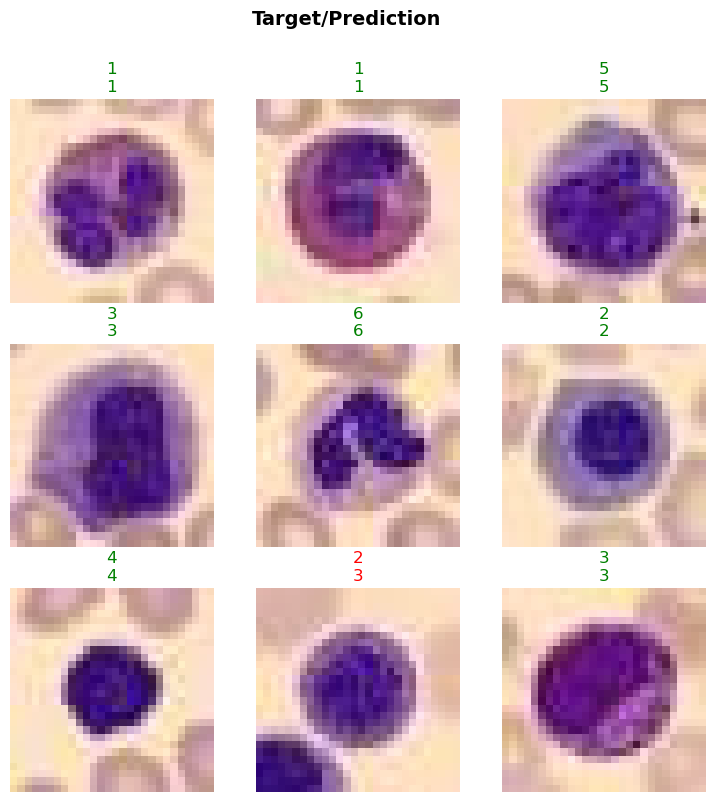

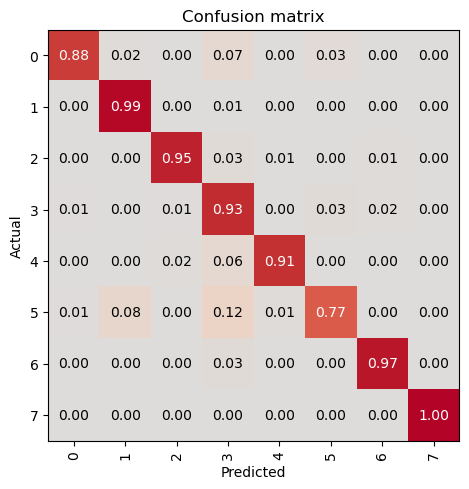

In [ ]:
evaluate_classification_model(trainer, test_data, metrics=metrics, show_graph=False);

### Load the Model

In this step, we will load the previously trained model using the `load` method of the `visionTrainer` class. In this example, we will:

> - Create a trainer instance and load the previously saved model.
> - Train the model a several epochs more.
> - Evaluate the model with test data again.

epoch,train_loss,valid_loss,accuracy,time
0,0.185844,1.430615,0.941589,00:18
1,0.164955,1.905653,0.944509,00:16
2,0.147714,0.939629,0.952687,00:16
3,0.133796,0.309621,0.957360,00:15
4,0.125237,0.236026,0.955023,00:16
5,0.124441,0.221759,0.958528,00:16
6,0.122997,0.233269,0.957360,00:15
7,0.132841,0.586334,0.952687,00:17
8,0.108366,0.164888,0.957360,00:16
9,0.115062,0.275192,0.956776,00:17


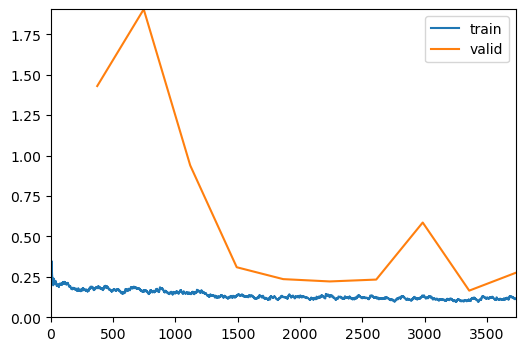

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       244
           1       0.98      0.99      0.99       624
           2       0.97      0.95      0.96       311
           3       0.86      0.92      0.89       579
           4       0.95      0.93      0.94       243
           5       0.91      0.85      0.88       284
           6       0.98      0.96      0.97       666
           7       1.00      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.95      0.94      0.94      3421
weighted avg       0.95      0.95      0.95      3421


Most Confused Classes:


[('5', '3', 29), ('6', '3', 20), ('3', '5', 18), ('0', '3', 13), ('4', '3', 12), ('3', '6', 11), ('2', '3', 10), ('3', '0', 7), ('3', '2', 5), ('5', '1', 5), ('0', '1', 4), ('1', '3', 4), ('3', '4', 3), ('5', '4', 3), ('2', '4', 2), ('4', '2', 2), ('4', '5', 2), ('5', '0', 2), ('6', '1', 2), ('0', '4', 1), ('0', '5', 1), ('0', '6', 1), ('1', '0', 1), ('2', '5', 1), ('2', '6', 1), ('2', '7', 1), ('3', '1', 1), ('4', '0', 1), ('4', '1', 1), ('5', '2', 1), ('6', '2', 1)]


,Value
CrossEntropyLossFlat,
Mean,1.335371
Median,1.275283
Standard Deviation,0.182275
Min,1.274009
Max,2.274009
Q1,1.274085
Q3,1.288040


,Value
accuracy,
Mean,0.950892
Median,1.000000
Standard Deviation,0.216094
Min,0.000000
Max,1.000000
Q1,1.000000
Q3,1.000000


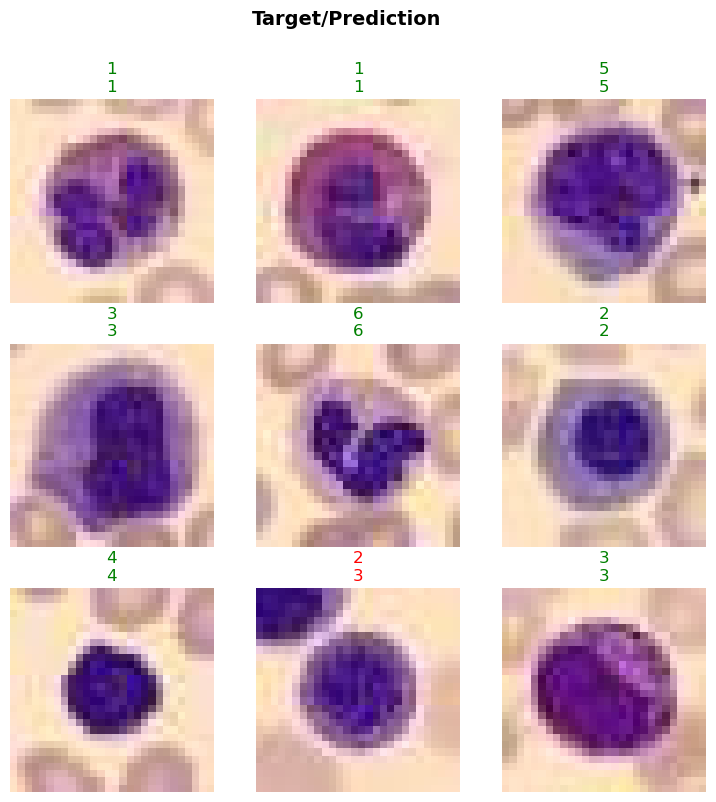

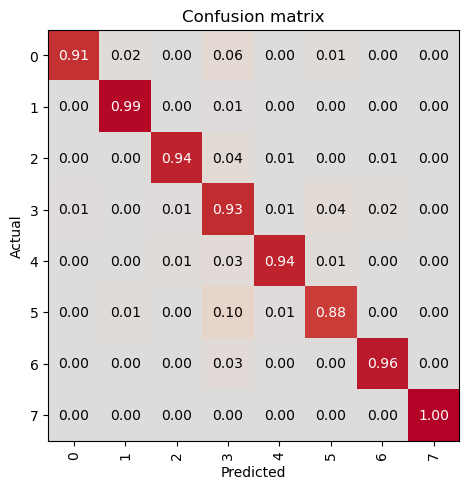

In [ ]:
model = resnet34

loss = CrossEntropyLossFlat()
metrics = accuracy

trainer2 = visionTrainer(data, model, loss_fn=loss, metrics=metrics, show_summary=False)

# Load saved model
trainer2.load('tmp-model')

# Train several additional epochs
trainer2.fit_one_cycle(10, lr_max=5e-5)

# Evaluate the model on the test dataset
evaluate_classification_model(trainer2, test_data, metrics=metrics, show_graph=False);